In [19]:
from keras.layers import Input, Dense, Conv2D, Add, Dot, Lambda, Conv2DTranspose, Dot, Activation, Reshape, BatchNormalization, UpSampling2D, AveragePooling2D, GlobalAveragePooling2D, Multiply, LeakyReLU, Flatten, MaxPool2D 
from keras.models import Model
import keras.backend as K
import tensorflow as tf

In [2]:
# Author: Jose Sepulveda
# Description: This is a keras implementation of spectral normalization.
#              This was proposed in this paper: https://arxiv.org/pdf/1802.05957.pdf
#


from keras import backend as K


# Stochastic Gradient Descent with Spectral Normalization:
#   1) Initialize a random vector u, initialized from an isotropic distribution.
#   2) Use the Power iteration method with this vector u on the matrix of wieghts
#      to obtain two approximations of eigenvectors.
#   3) Calculate the spectral norm of the wieghts matrix.
#   4) Update wieghts using vanilla SGD using the spectral norm of the wieghts matrix.

def spectral_norm(w):
    """
        Input: tensor of wieghts
        Output: SN tensor of wieghts
    """
    def l2_norm(v):
        return K.sum(v ** 2) ** 0.5

    w_dim = w.shape.as_list()[-1]
    # Initialize random vector u
    u = K.random_normal(shape=[1, w_dim])

    # We need to flatten the wieghts
    w_flat = K.reshape(w, [-1, w_dim])

    # Power iteration method
    v = K.dot(u, K.transpose(w_flat))
    v = v / l2_norm(v)
    u = K.dot(v, w_flat)
    u = u / l2_norm(u)

    # Calculate the SN of W
    sigma = K.dot(K.dot(v, w_flat), K.transpose(u))
    w_sn = w_flat / sigma

    # Update wieghts
    w_sn = K.reshape(w_sn, w.shape.as_list())
    return w_sn


In [3]:
def ResBlockDown(input_shape, channel_size, channel_multiplier=1, name=None):
    # Resblock architecture
    # 1 BatchNorm 
    # 2 ReLU activation
    # 3 Conv layer
    # 4 BatchNorm
    # 5 ReLU activation
    # 6 Conv layer
    # 7 Sum with input 
    
    #FIRST BLOCK
    #input layer
    input_layer = Input(shape=input_shape)
    
    # BatchNorm - needs to be conditional
    resblock = BatchNormalization()(input_layer)
    
    # Relu
    resblock = Activation('relu')(resblock)
    
    # Convolution size 3 filter as per paper
    # Need to spectrally normalize here somehow
    resblock = Conv2D(channel_size * channel_multiplier, 3, padding='same', strides=2)(resblock)
    #SECOND BLOCK
    
    # BatchNorm - needs to be conditional
    resblock = BatchNormalization()(resblock)
    # Relu
    resblock = Activation('relu')(resblock)
    # Convolution size 3 filter as per paper
    # Need to spectrally normalize here somehow
    resblock = Conv2D(channel_size * channel_multiplier, 3, padding='same')(resblock)
    # Downsample
    #resblock = AveragePooling2D()(resblock)
    
    # Time for the shortcut connection!
    
    shortcut_identity = Conv2D(channel_size * channel_multiplier, 3, padding='same', strides=2)(input_layer)
    #shortcut_identity = AveragePooling2D()(shortcut_identity)
    
    output_layer = Add()([shortcut_identity, resblock])
    
    return Model(input_layer, output_layer, name=name)
    





In [4]:
def ResBlockUp(input_shape, channel_size, channel_multiplier=1, name=None):
    # Resblock architecture
    # 1 BatchNorm 
    # 2 ReLU activation
    # 3 Conv layer
    # 4 BatchNorm
    # 5 ReLU activation
    # 6 Conv layer
    # 7 Sum with input 
    
    #FIRST BLOCK
    #input layer
    input_layer = Input(shape=input_shape)
    
    # BatchNorm - needs to be conditional
    resblock = BatchNormalization()(input_layer)
    
    # Relu
    resblock = Activation('relu')(resblock)
    
    # Convolution size 3 filter as per paper
    # Need to spectrally normalize here somehow
    resblock = Conv2DTranspose(channel_size * channel_multiplier, 3, padding='same', strides=2)(resblock)
    
    #SECOND BLOCK
    
    # BatchNorm - needs to be conditional
    resblock = BatchNormalization()(resblock)
    
    # Relu
    resblock = Activation('relu')(resblock)
    
    # Convolution size 3 filter as per paper
    # Need to spectrally normalize here somehow
    resblock = Conv2DTranspose(channel_size * channel_multiplier, 3, padding='same')(resblock)
    
    # Downsample
    #resblock = AveragePooling2D()(resblock)
    
    # Time for the shortcut connection!
    
    shortcut_identity = Conv2DTranspose(channel_size * channel_multiplier, 1, padding='same', strides=2)(input_layer)
    #shortcut_identity = AveragePooling2D()(shortcut_identity)
    output_layer = Add()([shortcut_identity, resblock])
    
    return Model(input_layer, output_layer, name=name)
    
    

In [5]:
def ResBlock(input_shape, channel_size, channel_multiplier=1, name=None):
     # Resblock architecture
    # 1 BatchNorm 
    # 2 ReLU activation
    # 3 Conv layer
    # 4 BatchNorm
    # 5 ReLU activation
    # 6 Conv layer
    # 7 Sum with input 
    
    #FIRST BLOCK
    #input layer
    input_layer = Input(shape=input_shape)
    
    # BatchNorm - needs to be conditional
    resblock = BatchNormalization()(input_layer) 
    # Relu
    resblock = Activation('relu')(resblock)
    # Convolution size 3 filter as per paper
    # Need to spectrally normalize here somehow
    resblock = Conv2D(channel_size * channel_multiplier, 3, padding='same')(resblock)
    
    #SECOND BLOCK   
    # BatchNorm - needs to be conditional
    resblock = BatchNormalization()(input_layer)    
    # Relu
    resblock = Activation('relu')(resblock)    
    # Convolution size 3 filter as per paper
    # Need to spectrally normalize here somehow
    resblock = Conv2D(channel_size * channel_multiplier, 3, padding='same')(resblock)
     
    # Time for the shortcut connection!   
    shortcut_identity = Conv2D(channel_size * channel_multiplier, 1, padding='same')(input_layer)
    output_layer = Add()([shortcut_identity, resblock])
    
    return Model(input_layer, output_layer, name=name)
    
    
    
    
    
    

In [26]:


def SelfAttentionBlock(input_shape, name=None):
    # f = conv
    channels = input_shape[-1]
    input_layer = Input(shape=input_shape)
    f = Conv2D(channels // 8, 1, padding='same')(input_layer)
    # f = maxpooling
    f = MaxPool2D(pool_size=2, strides=2, padding='same')(f)
    
    g = Conv2D(channels // 8, 1, padding='same')(input_layer)
    
    h = Conv2D(channels // 2, 1, padding='same')(input_layer)
    h = MaxPool2D(pool_size=2, strides=2, padding='same')(h)
    
    
    g = Reshape((-1, g.shape[-1]))(g)
    f = Reshape((-1, g.shape[-1]))(f)
    s = Dot(-1)([g, f])
    print("Shape of s:{}".format(s.shape))
    beta = Activation('softmax')(s)
    print("Shape of beta:{}".format(beta.shape))
    h = Reshape((-1, h.shape[-1]))(h)
    print("Shape of h:{}".format(h.shape))
    o = tf.matmul(beta, h)
    
    gamma = Conv2D(channels, (1, 1), padding='same', use_bias=False, kernel_initializer='he_normal')(input_layer)
    #gamma = Reshape((-1, channels // 2))(g)
    #print(gamma.shape)
    a, x, y ,z = input_layer.shape
    print(o.shape)
    #o = K.reshape(o, shape=[x,y,z, channels // 2])
    o = Reshape((-1,z,channels//2))(o)
    o = Conv2D(channels, kernel_size=1, strides=1)(o)
  
    Wz_yi = gamma * o
    output_layer = Add()([Wz_yi, input_layer])
    #output_layer = gamma*o + input_layer
    
    return Model(input_layer, output_layer, name=name)

In [27]:

def GlobalSumPooling2D(name=None):
    return Lambda(lambda inputs: K.sum(inputs, axis=[1, 2]), name=name)
        
# Discriminator test
def build_discriminator(channel_multiplier=64):
    input_shape = (128,128,3)
    model_input = Input(shape=input_shape, name="D_input")
    resblockdown1 = ResBlockDown(input_shape=input_shape,channel_size=1, channel_multiplier=channel_multiplier, name='D_resblock_down_1')
    h = resblockdown1(model_input)
    selfattentionblock = SelfAttentionBlock(input_shape=(64,64,32), name='D_self_attention_block')
    h = selfattentionblock(h)
    # Non local block should be here
    #print(h.shape)
    ch = channel_multiplier
    x = input_shape[0]
    y = input_shape[1]
    resblockdown2 = ResBlockDown(input_shape=(x,y,channel_multiplier),channel_size=2, channel_multiplier=channel_multiplier, name='D_resblock_down_2')
    h = resblockdown2(h)
    #print(h.shape)
    x = x // 2
    y = y // 2
    ch = ch * 2
    resblockdown4 = ResBlockDown(input_shape=(x,y,ch),channel_size=4, channel_multiplier=channel_multiplier, name='D_resblock_down_4')
    h = resblockdown4(h)
    x = x // 2
    y = y // 2
    ch = ch * 2
    #print(h.shape)
    resblockdown8 = ResBlockDown(input_shape=(x,y,ch),channel_size=8, channel_multiplier=channel_multiplier, name='D_resblock_down_8')
    
    h = resblockdown8(h)
    x = x // 2
    y = y // 2
    ch = ch * 2
    

    resblockdown16 = ResBlockDown(input_shape=(x,y,ch),channel_size=16, channel_multiplier=channel_multiplier, name='D_resblock_down_16')
    h = resblockdown16(h)
    x = x // 2
    y = y // 2
    ch = ch * 2
    resblock16 = ResBlock(input_shape=(x,y,ch),channel_size=16, channel_multiplier=channel_multiplier, name='D_resblock_16')
    h = resblock16(h)

    h = Activation('relu', name="D_relu")(h)
    h = GlobalSumPooling2D(name="D_global_sum_pooling_2D")(h)
    model_output = Dense(1, name="D_dense")(h)
    model = Model(model_input, model_output, name="Discriminator")
    return model

build_discriminator().summary

Shape of s:(?, ?, ?)
Shape of beta:(?, ?, ?)
Shape of h:(?, ?, 16)
(?, ?, 16)


ValueError: Dimensions must be equal, but are 64 and 32 for 'mul_1' (op: 'Mul') with input shapes: [?,64,64,32], [?,?,32,32].

In [28]:
# only noise, non conditional
def build_generator(channel_multiplier=64):

    model_input = Input(shape=(128,), name="G_input")
    h = Dense(4*4*16*channel_multiplier, name="G_dense")(model_input)
    h = Reshape((4,4,16*channel_multiplier))(h) # 512 = 16*ch
    resblockup16 = ResBlockUp(input_shape=(4,4,1024), channel_size=16, channel_multiplier=channel_multiplier, name="G_resblock_up_16")
    h = resblockup16(h)
    resblockup8 = ResBlockUp(input_shape=(8,8,1024), channel_size=8, channel_multiplier=channel_multiplier, name="G_resblock_up_8")
    h = resblockup8(h)
    resblockup4 = ResBlockUp(input_shape=(16,16,512), channel_size=4, channel_multiplier=channel_multiplier, name="G_resblock_up_4")
    h = resblockup4(h)

    resblockup2 = ResBlockUp(input_shape=(64,64,256), channel_size=2, channel_multiplier=channel_multiplier, name="G_resblock_up_2")
    h = resblockup2(h)
#     need to debug the following
    #selfattentionblock = SelfAttentionBlock(input_shape=(64,64,32), name='G_self_attention_block')
    #h = selfattentionblock(h)
    resblockup1 = ResBlockUp(input_shape=(128,128,128), channel_size=1, channel_multiplier=channel_multiplier, name="G_resblock_up_1")
    h = resblockup1(h)
    h = BatchNormalization()(h)
    h = Activation('relu')(h)
    model_output = Conv2D(3, kernel_size=3, strides=1, padding='same', activation='tanh')(h)
    
    return Model(model_input, model_output, name="Generator")
build_generator().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
G_input (InputLayer)         (None, 128)               0         
_________________________________________________________________
G_dense (Dense)              (None, 16384)             2113536   
_________________________________________________________________
reshape_26 (Reshape)         (None, 4, 4, 1024)        0         
_________________________________________________________________
G_resblock_up_16 (Model)     (None, 8, 8, 1024)        19934208  
_________________________________________________________________
G_resblock_up_8 (Model)      (None, 16, 16, 512)       7609856   
_________________________________________________________________
G_resblock_up_4 (Model)      (None, 32, 32, 256)       1904384   
_________________________________________________________________
G_resblock_up_2 (Model)      multiple                  477056    
__________

In [ ]:
def build_u_net_generator(channel_multiplier=64):

    model_input = Input(shape=(128,), name="G_input")
    h = Dense(4*4*16*channel_multiplier, name="G_dense")(model_input)
    h = Reshape((4,4,16*channel_multiplier))(h) # 512 = 16*ch
    resblockup16 = ResBlockUp(input_shape=(4,4,1024), channel_size=16, channel_multiplier=channel_multiplier, name="G_resblock_up_16")
    h = resblockup16(h)
    resblockup8 = ResBlockUp(input_shape=(8,8,1024), channel_size=8, channel_multiplier=channel_multiplier, name="G_resblock_up_8")
    h = resblockup8(h)
    resblockup4 = ResBlockUp(input_shape=(16,16,512), channel_size=4, channel_multiplier=channel_multiplier, name="G_resblock_up_4")
    h = resblockup4(h)

    resblockup2 = ResBlockUp(input_shape=(64,64,256), channel_size=2, channel_multiplier=channel_multiplier, name="G_resblock_up_2")
    h = resblockup2(h)
#     need to debug the following
    #selfattentionblock = SelfAttentionBlock(input_shape=(64,64,32), name='G_self_attention_block')
    #h = selfattentionblock(h)
    resblockup1 = ResBlockUp(input_shape=(128,128,128), channel_size=1, channel_multiplier=channel_multiplier, name="G_resblock_up_1")
    h = resblockup1(h)
    h = BatchNormalization()(h)
    h = Activation('relu')(h)
    model_output = Conv2D(3, kernel_size=3, strides=1, padding='same', activation='tanh')(h)
    
    return Model(model_input, model_output, name="Generator")

In [9]:
import glob
import cv2
import numpy as np
def dataLoader(datapath):
    edge_filepaths = sorted(glob.glob(datapath+'edge-*.png'))
    img_filepaths = sorted(glob.glob(datapath+'*.png'))
    edges = []
    imgs = []
    for edge_fp, img_fp in zip(edge_filepaths,img_filepaths):
        edge = cv2.imread(edge_fp, 0)
        img = cv2.imread(img_fp)
        edge[edge != 255] = 0
        edge = edge // 255
        edges.append(edge)
        imgs.append(img)
        
    return np.array(edges), np.array(imgs)
    

In [10]:
edges, imgs = dataLoader('./edge-data/')
print(edges.shape)



(8144, 128, 128)


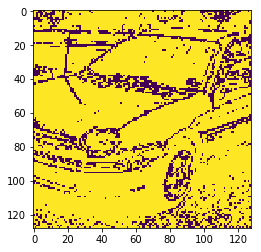

In [26]:
import matplotlib.pyplot as plt
plt.imshow(edges[346])
plt.show()


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from time import time

from keras.models import Model, Sequential
from keras import optimizers 
import keras.backend as K
from keras.utils.generic_utils import Progbar
from keras.optimizers import Adam

In [13]:
import tensorflow as tf
###################################
# TensorFlow wizardry
config = tf.ConfigProto()
 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.5
 
# Create a session with the above options specified.
K.tensorflow_backend.set_session(tf.Session(config=config))
###################################
 

In [14]:
#Hyperperemeter
BATCHSIZE=16
LEARNING_RATE = 0.0002
TRAINING_RATIO = 1
BETA_1 = 0.0
BETA_2 = 0.9
EPOCHS = 500
BN_MIMENTUM = 0.9
BN_EPSILON  = 0.00002
SAVE_DIR = 'gen-imgs/'

GENERATE_ROW_NUM = 4
GENERATE_BATCHSIZE = GENERATE_ROW_NUM*GENERATE_ROW_NUM

In [15]:

generator = build_generator()
discriminator = build_discriminator()

Noise_input_for_training_generator = Input(shape=(128,))
Generated_image                    = generator(Noise_input_for_training_generator)
Discriminator_output               = discriminator(Generated_image)
model_for_training_generator       = Model(Noise_input_for_training_generator, Discriminator_output)
print("model_for_training_generator")
discriminator.trainable = False
model_for_training_generator.summary()
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_for_training_generator.compile(optimizer=Adam(LEARNING_RATE, beta_1=BETA_1, beta_2=BETA_2), loss='mean_squared_error')

Instructions for updating:
Colocations handled automatically by placer.
model_for_training_generator
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 128)               0         
_________________________________________________________________
Generator (Model)            (None, 128, 128, 3)       32160771  
_________________________________________________________________
Discriminator (Model)        (None, 1)                 35618509  
Total params: 67,779,280
Trainable params: 32,150,787
Non-trainable params: 35,628,493
_________________________________________________________________


In [16]:
Real_image                             = Input(shape=(128,128,3))
Noise_input_for_training_discriminator = Input(shape=(128,))
Fake_image                             = generator(Noise_input_for_training_discriminator)
Discriminator_output_for_real          = discriminator(Real_image)
Discriminator_output_for_fake          = discriminator(Fake_image)

model_for_training_discriminator       = Model([Real_image,
                                                Noise_input_for_training_discriminator],
                                               [Discriminator_output_for_real,
                                                Discriminator_output_for_fake])
print("model_for_training_discriminator")
generator.trainable = False
discriminator.trainable = True
model_for_training_discriminator.compile(optimizer=Adam(LEARNING_RATE/1.5, beta_1=BETA_1, beta_2=BETA_2), loss=['mean_squared_error','mean_squared_error'])
model_for_training_discriminator.summary()

model_for_training_discriminator
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 128)          0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
Generator (Model)               (None, 128, 128, 3)  32160771    input_14[0][0]                   
__________________________________________________________________________________________________
Discriminator (Model)           (None, 1)            35618509    input_13[0][0]                   
                                                                 Generator[2

In [17]:
real_y = np.ones((BATCHSIZE, 1), dtype=np.float32)
fake_y = -real_y

In [18]:
X = imgs/255*2-1

In [19]:

test_noise = np.random.randn(GENERATE_BATCHSIZE, 128)
W_loss = []
discriminator_loss = []
generator_loss = []
for epoch in range(EPOCHS):
    np.random.shuffle(X)
    
    print("epoch {} of {}".format(epoch+1, EPOCHS))
    num_batches = int(X.shape[0] // BATCHSIZE)
    
    print("number of batches: {}".format(int(X.shape[0] // (BATCHSIZE))))
    
    progress_bar = Progbar(target=int(X.shape[0] // (BATCHSIZE * TRAINING_RATIO)))
    minibatches_size = BATCHSIZE * TRAINING_RATIO
    
    start_time = time()
    for index in range(int(X.shape[0] // (BATCHSIZE * TRAINING_RATIO))):
        progress_bar.update(index)
        discriminator_minibatches = X[index * minibatches_size:(index + 1) * minibatches_size]
        
        for j in range(TRAINING_RATIO):
            image_batch = discriminator_minibatches[j * BATCHSIZE : (j + 1) * BATCHSIZE]
            noise = np.random.randn(BATCHSIZE, 128).astype(np.float32)
            discriminator.trainable = True
            generator.trainable = False
            discriminator_loss.append(model_for_training_discriminator.train_on_batch([image_batch, noise],
                                                                                      [real_y, fake_y]))
        discriminator.trainable = False
        generator.trainable = True
        generator_loss.append(model_for_training_generator.train_on_batch(np.random.randn(BATCHSIZE, 128), real_y))
    
    print('\nepoch time: {}'.format(time()-start_time))
    
    W_real = model_for_training_generator.evaluate(test_noise, real_y)
    #print(W_real)
    W_fake = model_for_training_generator.evaluate(test_noise, fake_y)
    #print(W_fake)
    W_l = W_real+W_fake
    #print('wasserstein_loss: {}'.format(W_l))
    W_loss.append(W_l)
    #Generate image
    generated_image = generator.predict(test_noise)
    generated_image = (generated_image+1)/2
    for i in range(GENERATE_ROW_NUM):
        new = generated_image[i*GENERATE_ROW_NUM:i*GENERATE_ROW_NUM+GENERATE_ROW_NUM].reshape(128*GENERATE_ROW_NUM,128,3)
        if i!=0:
            old = np.concatenate((old,new),axis=1)
        else:
            old = new
    print('plot generated_image')
    plt.imsave('{}/epoch_{}.png'.format(SAVE_DIR, epoch), old)

epoch 1 of 500
number of batches: 509
  0/509 [..............................] - ETA: 0sWARNING:tensorflow:From C:\Users\Jose\Anaconda3\lib\site-packages\tensorflow\python\ops\math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
508/509 [============================>.] - ETA: 0s
epoch time: 246.57747316360474
16/16 [==============================] - 0s 5ms/step
plot generated_image
epoch 2 of 500
number of batches: 509
508/509 [============================>.] - ETA: 0s
epoch time: 233.60049271583557
16/16 [==============================] - 0s 5ms/step
plot generated_image
epoch 3 of 500
number of batches: 509
508/509 [============================>.] - ETA: 0s
epoch time: 232.94044256210327
16/16 [==============================] - 0s 5ms/step
plot generated_image
epoch 4 of 500
number of batches: 509
508/509 [============================>.] - ETA: 0s
epoch time: 232.5017814

KeyboardInterrupt: 

In [152]:
gen_img = generator.predict(test_noise)

In [153]:
gen_img = (gen_img +1)/2

In [154]:
gen_img

array([[[[0.8568259 , 0.77873147, 0.7490115 ],
         [0.85222054, 0.7882384 , 0.8131676 ],
         [0.846822  , 0.7554947 , 0.54355377],
         ...,
         [0.92997754, 0.88324034, 0.92553425],
         [0.9221339 , 0.8859236 , 0.8709059 ],
         [0.8447546 , 0.8508223 , 0.86675775]],

        [[0.77683294, 0.71496195, 0.79499555],
         [0.6143031 , 0.76517934, 0.73243475],
         [0.9018154 , 0.8817203 , 0.8182306 ],
         ...,
         [0.9754667 , 0.97314394, 0.98516893],
         [0.9705703 , 0.9692347 , 0.968985  ],
         [0.92441714, 0.8927977 , 0.8763908 ]],

        [[0.667995  , 0.793537  , 0.8577317 ],
         [0.84004986, 0.86460924, 0.8482611 ],
         [0.66421014, 0.6898828 , 0.79323053],
         ...,
         [0.97276604, 0.9887979 , 0.99215627],
         [0.9405527 , 0.9679005 , 0.97065294],
         [0.94424367, 0.9637456 , 0.9563525 ]],

        ...,

        [[0.39122728, 0.3916723 , 0.3942794 ],
         [0.27499598, 0.3531556 , 0.32414132]

In [9]:
plt.imshow(gen_img[7])

NameError: name 'plt' is not defined

In [12]:
import glob
image_fns = sorted(glob.glob("./gen-imgs/*.png"))

In [33]:
import os

for image_name in image_fns:
    split_name = image_name.split('/')
    filename = split_name[-1]
    path = "/".join(split_name[0:2])
    
    split_filename = filename.split('_')[-1]
    corrected_filename = split_filename.rjust(7, '0')
    full_path = "/".join([path, corrected_filename])
    print(full_path)
    os.rename(image_name, full_path)



./gen-imgs/000.png
./gen-imgs/001.png
./gen-imgs/010.png
./gen-imgs/100.png
./gen-imgs/101.png
./gen-imgs/102.png
./gen-imgs/103.png
./gen-imgs/104.png
./gen-imgs/105.png
./gen-imgs/106.png
./gen-imgs/107.png
./gen-imgs/108.png
./gen-imgs/109.png
./gen-imgs/011.png
./gen-imgs/110.png
./gen-imgs/111.png
./gen-imgs/112.png
./gen-imgs/113.png
./gen-imgs/114.png
./gen-imgs/115.png
./gen-imgs/116.png
./gen-imgs/117.png
./gen-imgs/118.png
./gen-imgs/119.png
./gen-imgs/012.png
./gen-imgs/120.png
./gen-imgs/121.png
./gen-imgs/122.png
./gen-imgs/123.png
./gen-imgs/124.png
./gen-imgs/125.png
./gen-imgs/126.png
./gen-imgs/127.png
./gen-imgs/128.png
./gen-imgs/129.png
./gen-imgs/013.png
./gen-imgs/130.png
./gen-imgs/131.png
./gen-imgs/132.png
./gen-imgs/133.png
./gen-imgs/134.png
./gen-imgs/135.png
./gen-imgs/136.png
./gen-imgs/137.png
./gen-imgs/138.png
./gen-imgs/139.png
./gen-imgs/014.png
./gen-imgs/140.png
./gen-imgs/141.png
./gen-imgs/142.png
./gen-imgs/143.png
./gen-imgs/144.png
./gen-imgs/1

In [37]:
filenames = sorted(glob.glob("./gen-imgs/*.png"))

In [38]:
import imageio

In [41]:
images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('./gen-imgs/first_attempt.gif', images)